In [23]:
%matplotlib notebook
import serial
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.path import Path
from time import time
from scipy.signal import argrelextrema
from scipy import signal

ser = serial.Serial('COM3', 115200)
# set plot to animated
plt.ion() 

In [24]:
Wn = 0.05
b, a = signal.butter(3, Wn)
zi = signal.lfilter_zi(b, a)

<IPython.core.display.Javascript object>


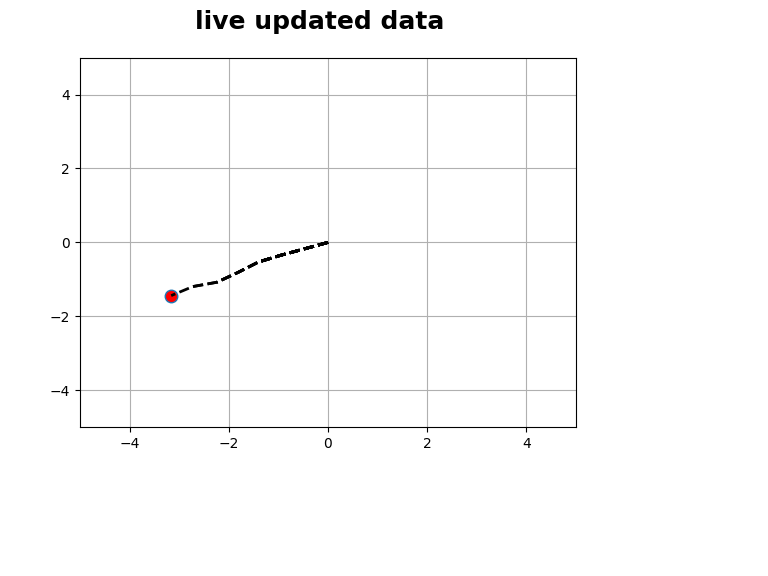

calibrating
calibrating done
Steps: 0
Steps: 0
Steps: 0
Steps: 1
Steps: 1
Steps: 1
Steps: 1
Steps: 1
Steps: 1
Steps: 1
Steps: 1
Steps: 1
Steps: 1
Steps: 1
Steps: 1
Steps: 1
Steps: 1
Steps: 1
Steps: 1


<IPython.core.display.Javascript object>

ValueError: x and y must have same first dimension, but have shapes (969,) and (970,)

In [25]:
start_time = time()
timepoints = []
accel = []
accelfor = []
angle =[]
x = 0
y = 0
mrange = [-5, 5] #map range
yrange = [-180,180]
view_time = 1 # seconds of data to view at once
duration = 10 # total seconds to collect data
ind = 0
steplim = 400
forlim = 500

# correction offset
accelcor = 1800  
accelforcor = 3000

# Store Location
verts = [(0,0)]

fig1 = plt.figure()
fig1.suptitle('live updated data', fontsize='18', fontweight='bold')
#plt.xlabel('time, seconds', fontsize='14', fontstyle='italic')
#plt.ylabel('potential, volts', fontsize='14', fontstyle='italic')
plt.axes().grid(True)
line1, = plt.plot(accel,marker='o',markersize=9,linestyle='none',markerfacecolor='red')
ax = fig1.add_subplot(111)
plt.ylim(mrange)
plt.xlim(mrange)

#fig = plt.figure()
#path = Path([(0.,0.)], [Path.MOVETO])
#pathbeg = (0.,0.)
#plt.show

calib_tim = 10
print('calibrating')
while (time() < start_time + calib_tim):
    #just read data to get calibration moving
    ser.reset_input_buffer()
    data = ser.readline()

print('calibrating done')
start_time = time()

run =  True
# collect the data and plot a moving frame
while run:
    run2 = True
    #start2 = time()
    startind = ind
    #print(time())
    
    iloop = 0
    # Loop to get a chunk of data to later process
    while run2:
        
        ser.reset_input_buffer()
        data = ser.readline()
        data = data.decode().split()
        #print(data)

        #reject if data is cut off
        try:
            if ((len(data[0]) < 4) or (len(data[1]) < 3)):
                continue
            #print(data)
        except IndexError:
            continue
        
        try:
            # store the entire dataset for later
            accel.append(float(data[1]) - accelcor) #acceleration up/down
            angle.append(float(data[0])) #angle
            accelfor.append(float(data[2]) - accelforcor) # acceleration forward/backward
            timepoints.append(time()-start_time)
            current_time = timepoints[-1]

            # update the plotted data
            #line1.set_xdata(timepoints)
            #line1.set_ydata(accel)

            # slide the viewing frame along
            #if current_time > view_time:
            #    plt.xlim([current_time-view_time,current_time])
            
            iloop = iloop + 1

            # when time's up, kill the collect+plot loop
            if timepoints[-1] > duration: run=False
            if iloop > 50: run2 = False

        # if the try statement throws an error, just do nothing
        except: pass

        # update the plot
        #fig1.canvas.draw()
        ind = ind + 1
   
    # MOVING AVERAGE OF ACCELERATION UP/DOWN
    window_width = 10 
    #z, _ = signal.lfilter(b, a, accel[startind:ind], zi=zi*accel[startind])
    cumsum_vec = np.cumsum(np.insert(accel[startind:ind], 0, 0)) 
    ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
#    if ind <= window_width:
#        cumsum_vec = np.cumsum(np.insert(accel, 0, 0)) 
#        ma_vec = cumsum_vec / (ind + 1)
#    else: 
#        #cumsum_vec[ind] = cumsum_vec[ind-1] + accel[ind]
#        cumsum_vec = np.cumsum(np.insert(accel, 0, 0)) 
#        ma_vec = (cumsum_vec[ind] - cumsum_vec[ind-window_width]) / window_width
#    maxInd = np.array(argrelextrema(ma_vec[startind:ind], np.greater)[0])

    # determine the indices of the local maxima
    maxInd = np.array(argrelextrema(ma_vec, np.greater)[0])
    
    # get the actual values using these indices
    peaks = ma_vec[maxInd]  # array([5, 3, 6]) peak moving average accel values
    stepind = np.nonzero(peaks > steplim)[0] # index of local maxima that are higher than 500
    stepsamp = maxInd[stepind]  # index of whole sample vector where step occurs
    peaks = peaks[stepind]      
    stepsize = 0.5 
    step = peaks.shape[0]
    dist = step* stepsize # number of estimated steps times distance of 1 step
    #print(dist)
    #print(cumsum_vec)
    print('Steps: ' + str(step))
    
    # MOVING AVERAGE OF ACCELERATION FORWAD/BACKWARD
    cumsum_vec = np.cumsum(np.insert(accelfor[startind:ind], 0, 0)) 
    ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    
                       
                   
    # polar to cartesian coordinates
#    print(stepsamp.shape)
#    print(stepsamp)
#    print(type(stepsamp[0]))
#    print(len(angle))
    for samp in stepsamp:
        
        # Find whether step was forward/backward or in place
        stepfor = ma_vec[samp]  # forward acceleration at moment of step
        if (stepfor > forlim): direction = 1
        if (stepfor < -forlim): direction = -1
        else: direction = 0
            
        # take angle and find distance for each step
        anglestep = angle[samp + startind]
        #print('Angle: ' + str(anglestep))
        x = direction*stepsize*np.cos(np.deg2rad(anglestep)) + x
        y = direction*stepsize*np.sin(np.deg2rad(anglestep)) + y
    
    #print('%f %f'%(x,y))
    line1.set_xdata(x)
    line1.set_ydata(y)
    #fig1.canvas.draw()
    
    verts.append((x,y))
    xs, ys = zip(*verts)
    ax.plot(xs, ys, '--', lw=2, color='black', ms=10)
    fig1.canvas.draw()
    



    
fig2 = plt.figure()
fig2.suptitle('complete data trace', fontsize='18', fontweight='bold')
plt.xlabel('time, seconds', fontsize='14', fontstyle='italic')
plt.ylabel('Angle', fontsize='14', fontstyle='italic')
plt.axes().grid(True)

plt.plot(timepoints, angle,marker='o',markersize=4,linestyle='none',markerfacecolor='red')
plt.ylim(yrange)
fig2.show()

plt.figure()
plt.plot(accel)
plt.figure()
window_width = 10
z, _ = signal.lfilter(b, a, accel, zi=zi*accel[0])
                                      
cumsum_vec = np.cumsum(np.insert(accel, 0, 0)) 
ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
plt.plot(ma_vec)


# determine the indices of the local maxima
maxInd = np.array(argrelextrema(ma_vec, np.greater)[0])

# get the actual values using these indices
r = ma_vec[maxInd]  # array([5, 3, 6])
stepind = np.nonzero(r > steplim)[0] # index of local maxima that are higher than 500
stepsamp = maxInd[stepind]
r = r[stepind]
stepsize = 0.5 
step = r.shape[0]
disp = np.sqrt(x**2+y**2) # number of estimated steps times distance of 1 step
print('Total steps: ' + str(step))
print('Total displacement: ' + str(disp))

plt.figure()
plt.plot(accelfor)
plt.figure()
window_width = 10

cumsum_vec = np.cumsum(np.insert(accelfor, 0, 0)) 
ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
plt.plot(ma_vec)


ser.close()

In [22]:
ser.close()